In [12]:
import pycuda.driver as cuda

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import draw, exposure, io, filters
import scipy.ndimage as ndi
import os
import re
import ast
import time
import glob
import seaborn as sns
import cv2
import pandas as pd

In [14]:
from quanfima import morphology as mrph
from quanfima import visualization as vis
from quanfima import utils

In [15]:
cv2.setNumThreads(35)

## 3D patch extraction routines

In [108]:
import numpy as np

def compute_patch_indices(data_shape, patch_shape, overlap, start=None):
    """
    Returns a list of corner indices of patches.
    :param data_shape: Shape of the data
    :param patch_shape: Shape or size of the patch
    :param overlap_size: Shape or size of the patch
    :param start: A starting point.
    :return: a list containing the corner indices which can be used to get patches from an image.
    """
    def _get_set_of_patch_indices(start, stop, step):
        if isinstance(step, int):
            step = np.ones_like(start) * step
        slices = [slice(_start, _stop, _step) for _start, _stop, _step in zip(start, stop, step)]
        return np.asarray(np.mgrid[slices].reshape(len(slices), -1).T, dtype=np.int)
               
    if isinstance(patch_shape, int):
        patch_shape = np.asarray([patch_shape] * len(data_shape))
    elif len(patch_shape) != len(data_shape):
        raise ValueError("The patch shape should be an integer or of the same dimension as the data. " + 
                         "patch_shape={0}, data_shape={1}".format(patch_shape, data_shape))
    
    if isinstance(overlap, int):
        overlap = np.asarray([overlap] * len(patch_shape))
    elif len(overlap) != len(data_shape):
        raise ValueError("The overlap should be an integer or of the same dimension as the data. " + 
                         "overlap={0}, data_shape={1}".format(overlap, data_shape))
        
    if isinstance(start, int):
        start = np.asarray([start] * len(data_shape))
    elif start is not None and len(start) != len(data_shape):
        raise ValueError("The start should be an integer or of the same dimension as the data. " + 
                         "start={0}, data_shape={1}".format(start, data_shape))
    else:   
        data_shape = np.asarray(data_shape)
        patch_shape = np.asarray(patch_shape)
        overlap = np.asarray(overlap)
        n_patches = np.ceil(data_shape / (patch_shape - overlap))
        n_patches = int(n_patches)
        overflow = (patch_shape - overlap) * n_patches - data_shape + overlap
        start = -np.ceil(overflow/2)
        start = int(start)
    
    stop = data_shape + start
    step = patch_shape - overlap
    return _get_set_of_patch_indices(start, stop, step)


def get_random_nd_index(index_max):
    return tuple([np.random.choice(index_max[index] + 1) for index in range(len(index_max))])


def get_random_patch_index(image_shape, patch_shape):
    """
    Returns a random corner index for a patch. If this is used during training, the middle pixels will be seen by
    the model way more often than the edge pixels (which is probably a bad thing).
    :param image_shape: Shape of the image
    :param patch_shape: Shape of the patch
    :return: a tuple containing the corner index which can be used to get a patch from an image
    """
    return get_random_nd_index(np.subtract(image_shape, patch_shape))


def reconstruct_from_patches(patches, patch_indices, data_shape, default_value=0, average=True):
    """
    Reconstructs an array of the original shape from the lists of patches and corresponding patch indices. Overlapping
    patches are averaged.
    :param patches: List of numpy array patches.
    :param patch_indices: List of indices that corresponds to the list of patches.
    :param data_shape: Shape of the array from which the patches were extracted.
    :param default_value: The default value of the resulting data. if the patch coverage is complete, this value will
    be overwritten.
    :return: numpy array containing the data reconstructed by the patches.
    """
    data = np.ones(data_shape) * default_value
    count = np.zeros(data_shape, dtype=np.int)
    
    for patch, index in zip(patches, patch_indices):
        index = index.copy()
        if np.any(index < 0):
            roi_patch = []
            for idx, dsize, psize in zip(index, data_shape, patch.shape):
                roi_patch.append(slice(np.abs(idx), None) if idx < 0 else slice(0, None))
            roi_patch = tuple(roi_patch)
            
            patch = patch[roi_patch]
            index[index < 0] = 0
        
        if np.any((index + patch.shape) >= data_shape):
            roi_patch = []
            for idx, dsize, psize in zip(index, data_shape, patch.shape):
                roi_patch.append(slice(0, psize - (idx + psize - dsize)) if (idx + psize) >= dsize else slice(0, psize))
            roi_patch = tuple(roi_patch)
            
            patch = patch[roi_patch]

        roi = tuple(slice(idx, idx+psize) for idx, psize in zip(index, patch.shape))
        count_roi = count[roi]
        data[roi][count_roi == 0] = patch[count_roi == 0]
        
        if np.any(count_roi > 0) and average:
            data_roi_avg = (data[roi] * count_roi + patch) / (count_roi + 1)
            data[roi][count_roi > 0] = data_roi_avg[count_roi > 0]
        
        count[roi] += 1
        
    return data


def get_ndpatch(data, patch_shape, patch_index):
    """
    Returns a patch from a numpy array.
    :param data: numpy array from which to get the patch.
    :param patch_shape: shape/size of the patch.
    :param patch_index: corner index of the patch.
    :return: numpy array take from the data with the patch shape specified.
    """
    import itertools
    def _find_crossing_hyperplanes(dsize, psize, pindex):
        from math import ceil, floor
        start, stop = pindex, pindex + psize
        dhplanes = [start]
        phplanes = [0]
        position = start
        nsteps = int(ceil(psize / dsize)) + 1
        for i in range(0, nsteps):
            virt_data_boundary = (int(floor(position / dsize)) + 1) * dsize
            virt_data_boundary = stop if stop <= virt_data_boundary else virt_data_boundary
            dhplanes.append(virt_data_boundary)
            phplanes.append(phplanes[-1] + abs(virt_data_boundary - position))
            if virt_data_boundary == stop:
                break
            
            position = virt_data_boundary
        return dhplanes, phplanes
    
    def _get_slices(dsize, dhplanes, phplanes):
        from math import ceil, floor
        dregions = list(zip(dhplanes[0:], dhplanes[1:]))
        pregions = list(zip(phplanes[0:], phplanes[1:]))
        
        pslices = [slice(start, stop) for start, stop in pregions]
        dslices = []
        for start, stop in dregions:
            distance = max(abs(start), abs(stop))
            k = ceil(float(distance) / dsize) + (-1 if start >= 0 else 0)
            k = int(k)
            mirroring = k % 2
            
            step = 1
            if start < 0:
                start = k * dsize + start
                stop = k * dsize + stop
            else:
                start = start - k * dsize
                stop = stop - k * dsize

            if mirroring:
                start = dsize - start - 1
                stop = dsize - stop - 1
                step = -1

            if stop < 0:
                stop = None

            dslices.append(slice(start, stop, step))
        
        return dslices, pslices
    
    patch_shape = tuple(int(v) for v in patch_shape)
    patch_index = tuple(int(v) for v in patch_index)
    
    dslices, pslices = [], []
    for dsize, psize, pindex in zip(data.shape, patch_shape, patch_index):
        dhplanes, phplanes = _find_crossing_hyperplanes(dsize, psize, pindex)
        _dslices, _pslices = _get_slices(dsize, dhplanes, phplanes)
        dslices.append(_dslices)
        pslices.append(_pslices)
    

    drois = list(itertools.product(*dslices))
    prois = list(itertools.product(*pslices))
    
    patch = np.zeros(patch_shape, dtype=data.dtype)
    for droi, proi in zip(drois, prois):
        patch[proi] = data[droi]
    
    return patch

In [16]:
def get_dtype_number(dtype):
    return int(re.findall(r'\d+', str(dtype))[-1])

In [17]:
def str_convert(string):
    try:
        val = ast.literal_eval(string)
    except ValueError:
        val = str(string)
        
    return val

In [18]:
def prepare_paths(input_pattern, invert=False, exclude_keywords=None):
    paths = glob.glob(input_pattern)
    if exclude_keywords is not None:
        paths = filter(lambda path: not any([kw in path for kw in exclude_keywords]), paths)

    return paths

In [19]:
def convert_to_8bit(data, percentile=None):
    if percentile is None:
        p1, p2 = np.percentile(data, 0.01), np.percentile(data, 99.9)
        print (p1, p2)
    else:
        p1, p2 = percentile
    
    data = exposure.rescale_intensity(data, in_range=(p1, p2), out_range=(0, 255))
    return (data.astype(np.uint8), (p1, p2))

In [20]:
def save_raw(data, output_dir, basename, shape, dtype):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    dtype_digit = get_dtype_number(dtype)
    out_path = '{}_{}bit_{}x{}x{}.raw'.format(basename, dtype_digit, *shape[::-1])
    out_path = os.path.join(output_dir, out_path)
    
    print 'Saving: ' + out_path
    
    data.tofile(out_path)
    return out_path

In [73]:
def open_data(filepath, 
              big_edian=False,
              dtype=np.float32, 
              regex_pattern=r'(?P<name>\w+\d+)_(?P<zoom>\d+\w+)_\w+_(?P<bit>\d+\w+)_(?P<width>\d+)x(?P<height>\d+)x(?P<depth>\d+)'):
    r = re.match(regex_pattern, os.path.basename(filepath))
    shape = (r.group('depth'), r.group('height'), r.group('width'))
    basename = r.group('name')
    bits = r.group('bit')
    shape = tuple([str_convert(v) for v in shape])
    print shape, dtype
    data = np.memmap(filepath, shape=shape, dtype=dtype, mode='r').copy()
    if big_edian:
        data.byteswap(inplace=True)
    print (basename, bits, shape)
    return (data, basename)

In [74]:
def show_slice(data, idx):
    plt.figure(figsize=(12,12))
    plt.imshow(data[idx], cmap='gray')
    plt.grid(False)

## Process datasets

In [75]:
def process_dataset(input_path, output_dir, strength=10, block_size=7, search_window=21, fiber_window=22):
    data, basename = open_data(input_path, big_edian=True, regex_pattern=r'(?P<name>\w+\d+)_\d+\w+_\w+_\w+_\w+_(?P<bit>\d+\w+)_(?P<width>\d+)x(?P<height>\d+)x(?P<depth>\d+)')

    # 8-bit conversion
    # data_8bit = convert_to_8bit(data.byteswap())[0]
    data_8bit = convert_to_8bit(data)[0]
    show_slice(data_8bit, data_8bit.shape[0]//2)              
    save_raw(data_8bit, output_dir, basename, data_8bit.shape, data_8bit.dtype)
    
    # Non-local means filtering
    data_filtered = np.array([cv2.fastNlMeansDenoising(slc, None, strength, block_size, search_window) for slc in data_8bit])
    show_slice(data_filtered, data_filtered.shape[0]//2)
    save_raw(data_filtered, output_dir, basename + '_filtered', data_8bit.shape, data_8bit.dtype)
    
    # Segmentation
    data_segmented = (data_filtered > filters.threshold_otsu(data_filtered)).astype(np.uint8)
    show_slice(data_segmented, data_segmented.shape[0]//2)
    save_raw(data_segmented, output_dir, basename + '_segmented', data_segmented.shape, data_segmented.dtype)
    
    # Fiber analysis
    _, skel, skel_thick = utils.prepare_data(data_segmented)
    orientation_props =  mrph.estimate_tensor_parallel('{}_orientation_w{}'.format(basename, fiber_window), 
                                                       skel, skel_thick, 
                                                       fiber_window, output_dir, 
                                                       n_processes=36)
    orientation_data = np.load(orientation_props['output_path']).item()
    
    diameter_props = mrph.estimate_diameter_single_run('{}_diameter'.format(basename), 
                                                       output_dir,
                                                       data_segmented, 
                                                       orientation_data['skeleton'],
                                                       orientation_data['lat'],
                                                       orientation_data['azth'])

In [76]:
input_paths = prepare_paths('/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/*.raw')

(480, 600, 600) <type 'numpy.float32'>
('sample7', '32bit', (480, 600, 600))
(-0.0029034961490659044, 0.0038916785290930775)
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample7_8bit_600x600x480.raw
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample7_filtered_8bit_600x600x480.raw
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample7_segmented_8bit_600x600x480.raw
333569
Tensor parallel time: 82.939127s
Diameter estimation time: 0.026508s
Total diameter execution time: 0.0265079994202
(260, 600, 600) <type 'numpy.float32'>
('sample6', '32bit', (260, 600, 600))
(-0.004833995838137343, 0.004186748062260465)
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample6_8bit_600x600x260.raw
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample6_filtered_8bit_60

/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample1_segmented_8bit_600x600x780.raw
817103
Tensor parallel time: 381.817022s
Diameter estimation time: 0.034588s
Total diameter execution time: 0.0345877113342
(251, 600, 600) <type 'numpy.float32'>
('sample2', '32bit', (251, 600, 600))
(-0.0025682281707646326, 0.0016600764368195284)
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample2_8bit_600x600x251.raw
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample2_filtered_8bit_600x600x251.raw
Saving: /mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample2_segmented_8bit_600x600x251.raw
330601
Tensor parallel time: 23.649432s
Diameter estimation time: 0.024794s
Total diameter execution time: 0.0247942714691


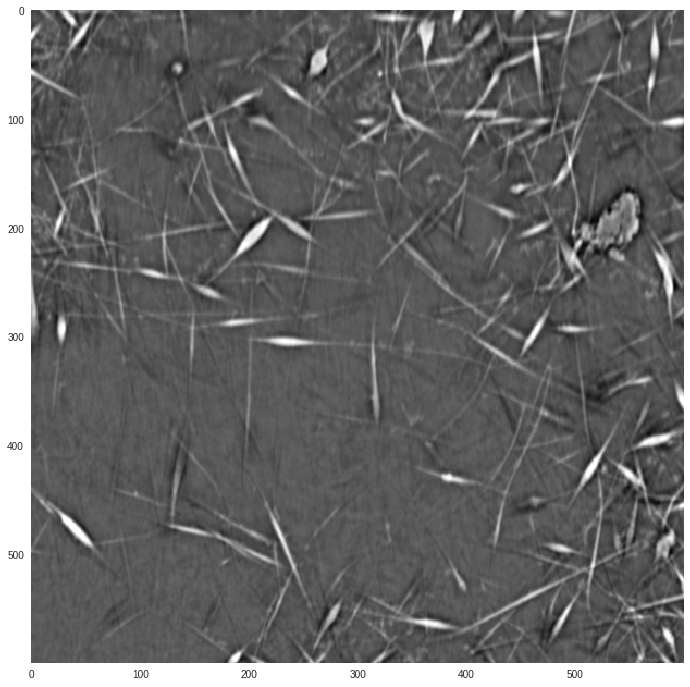

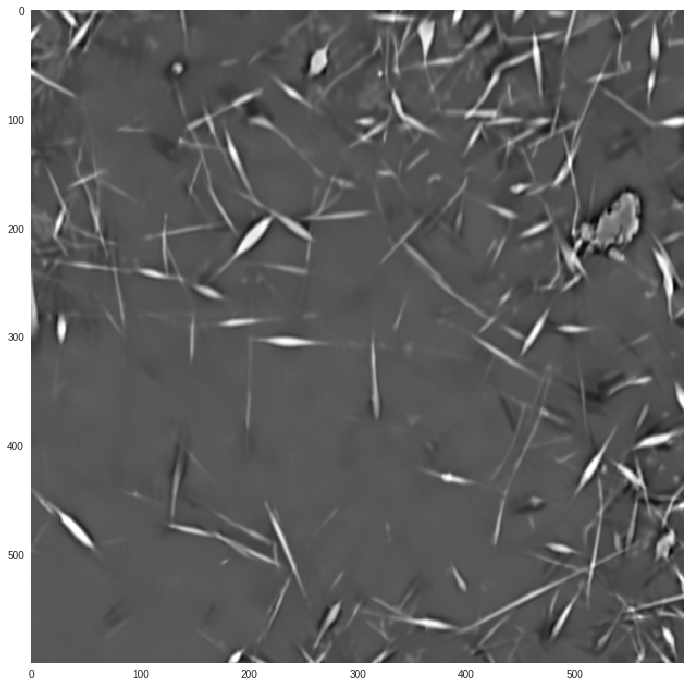

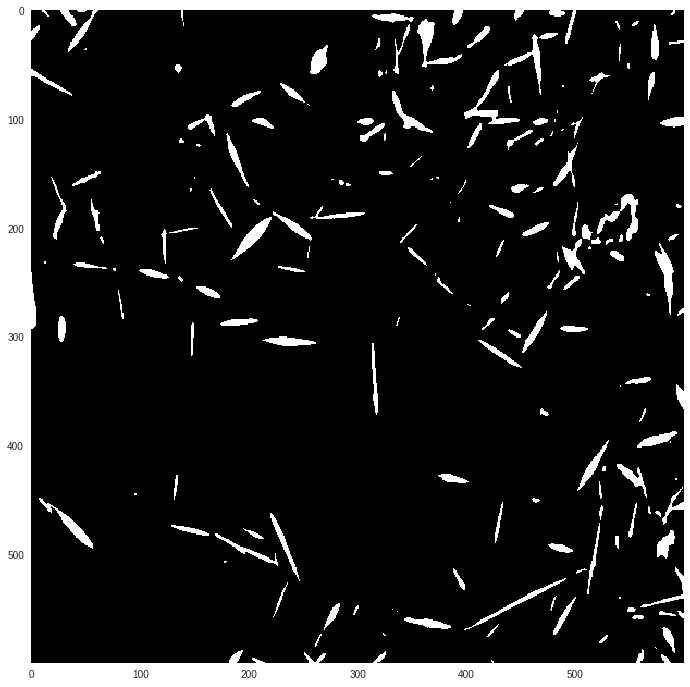

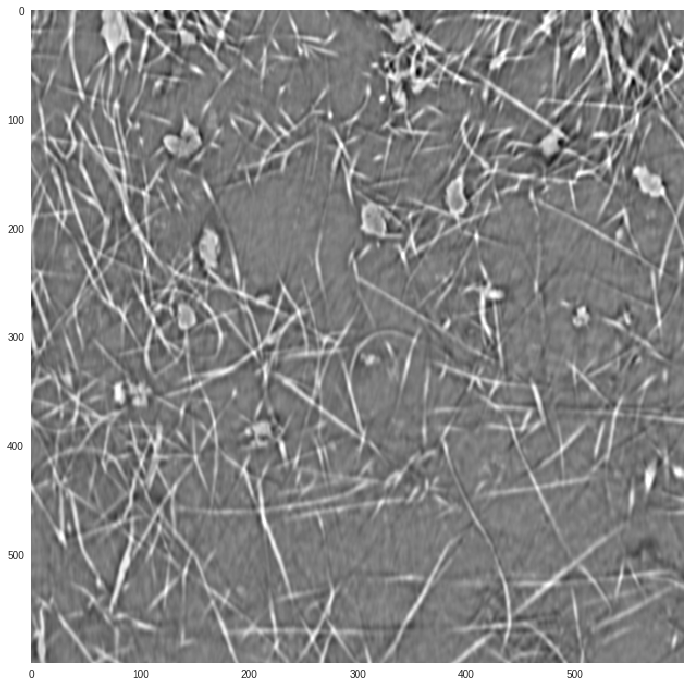

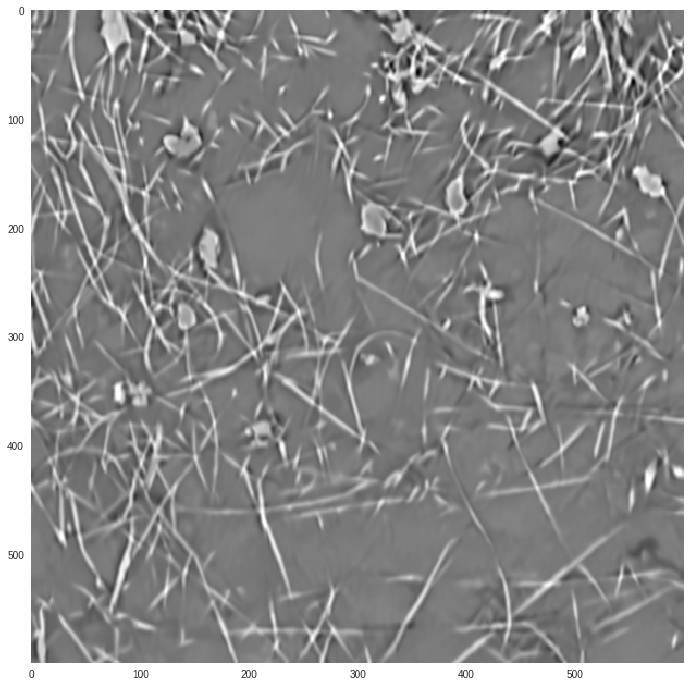

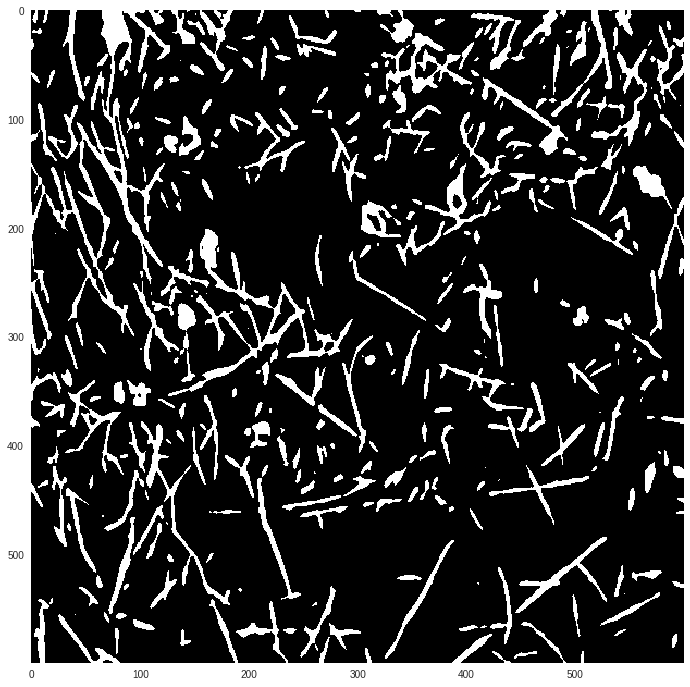

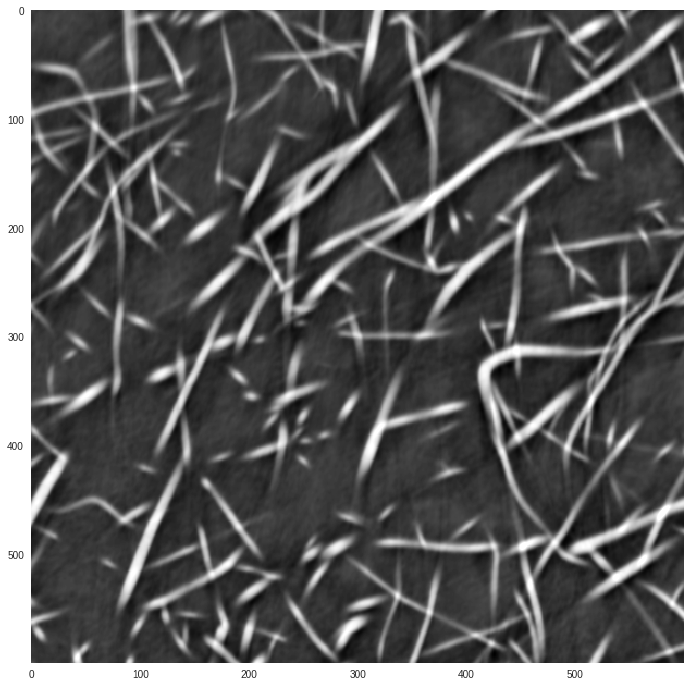

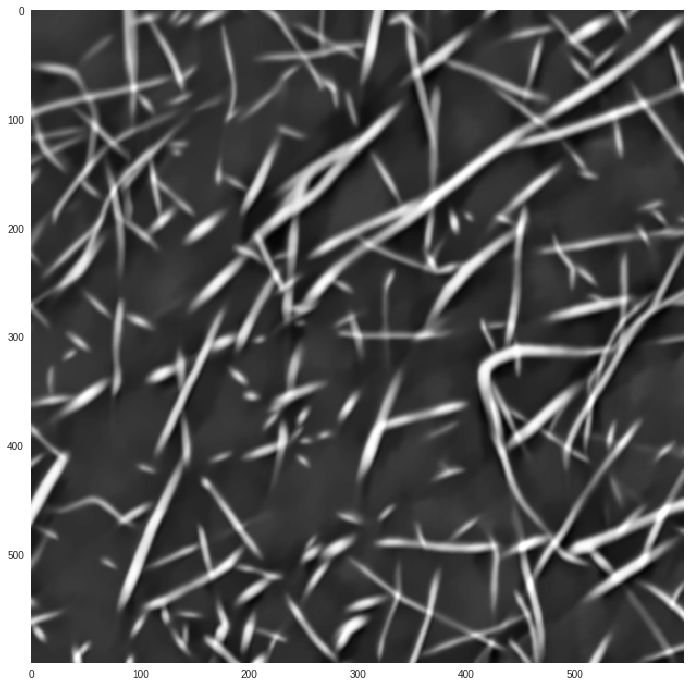

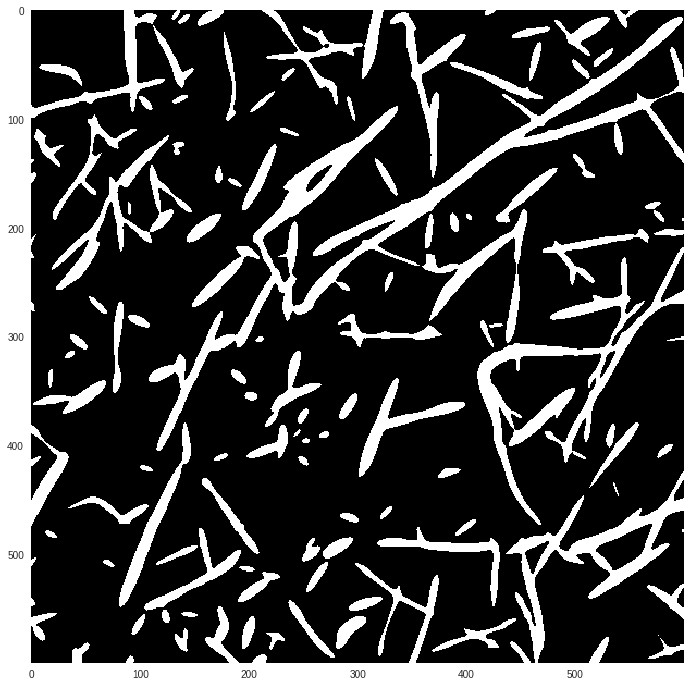

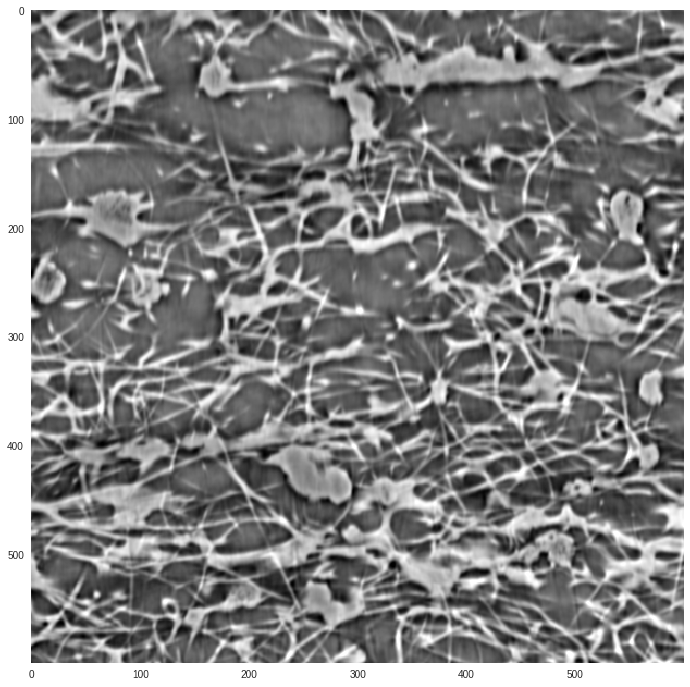

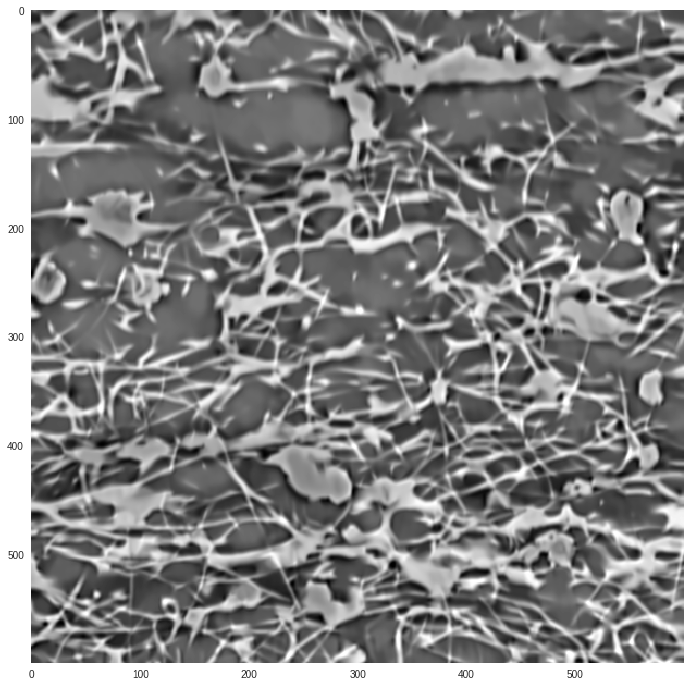

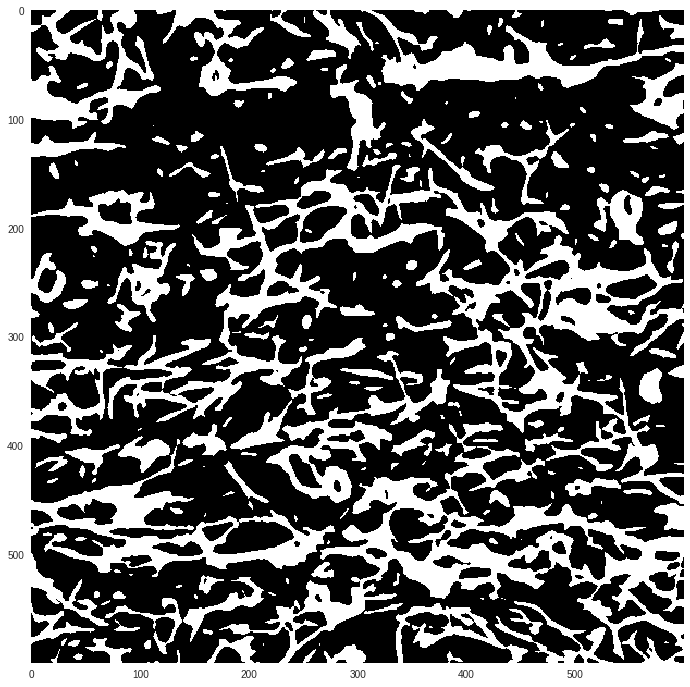

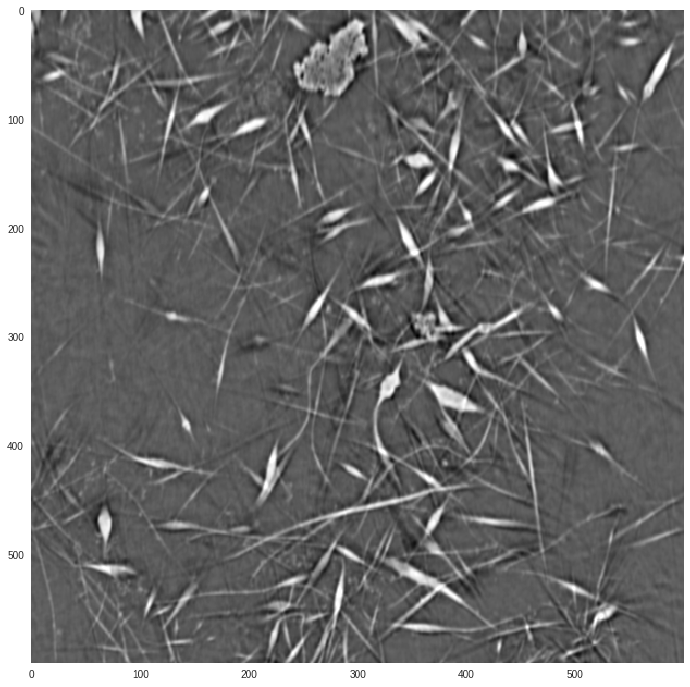

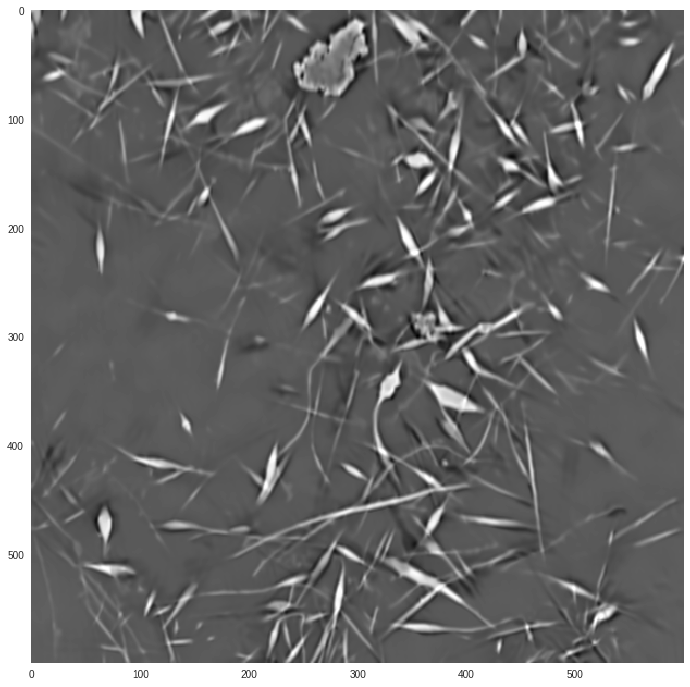

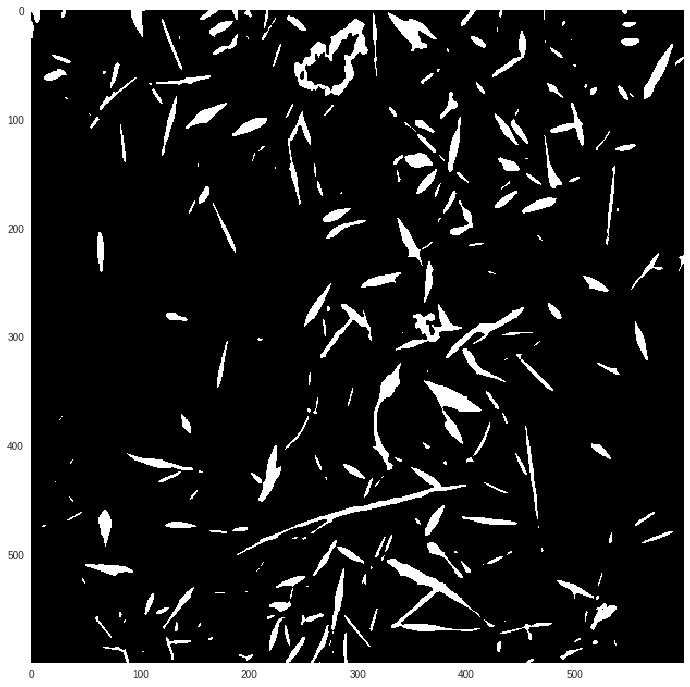

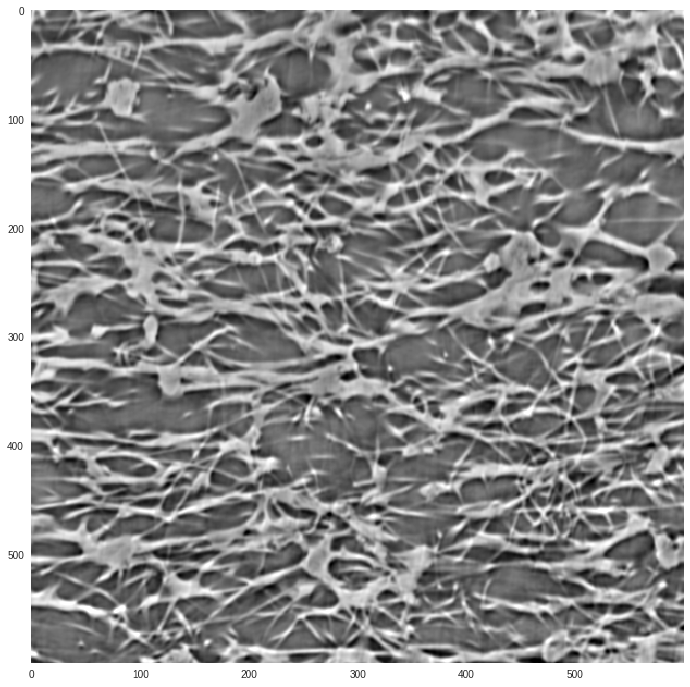

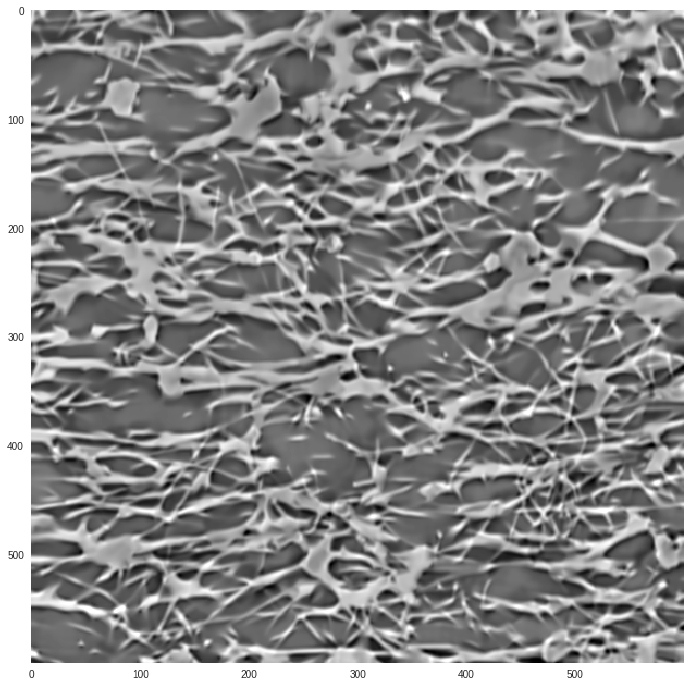

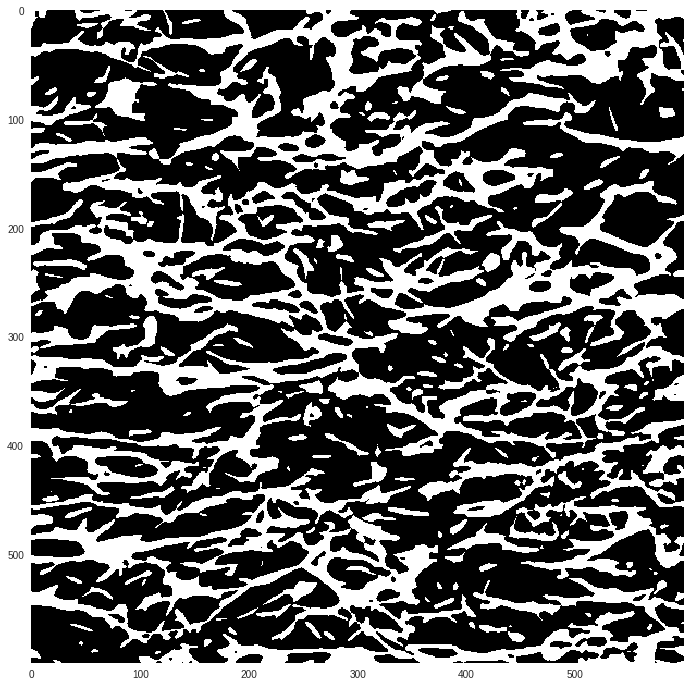

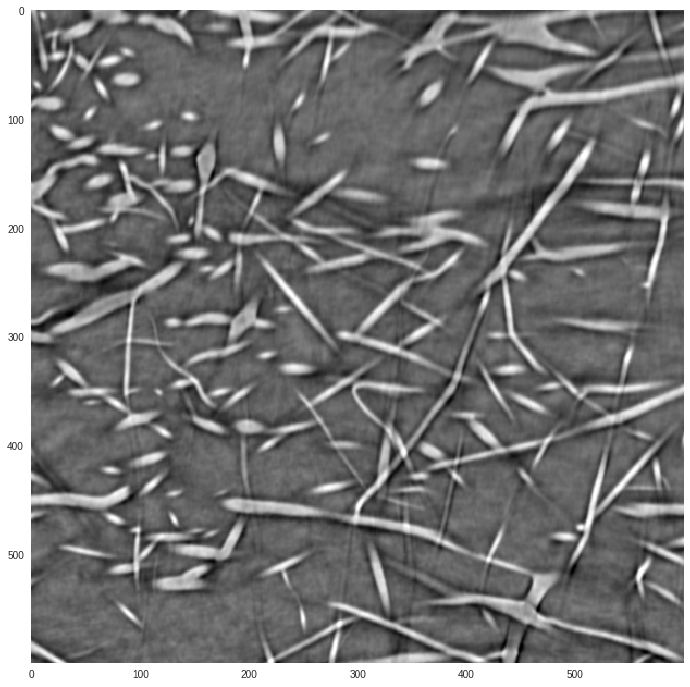

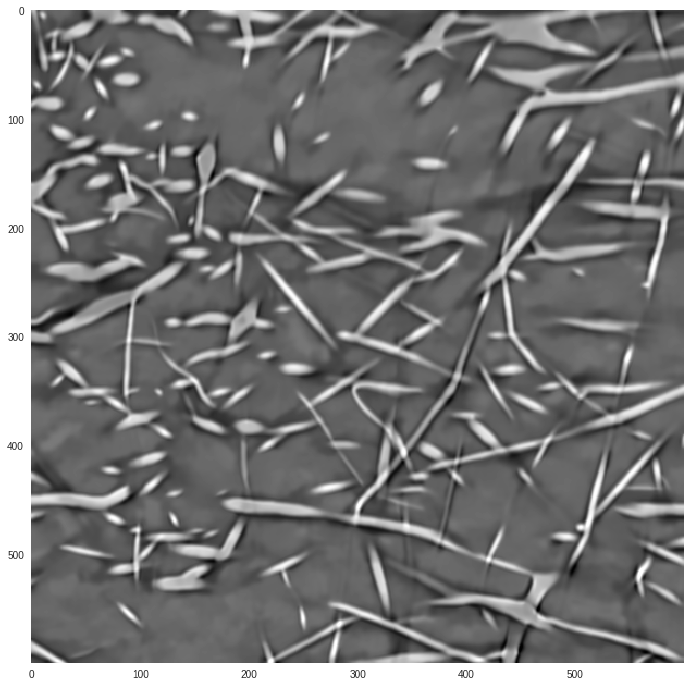

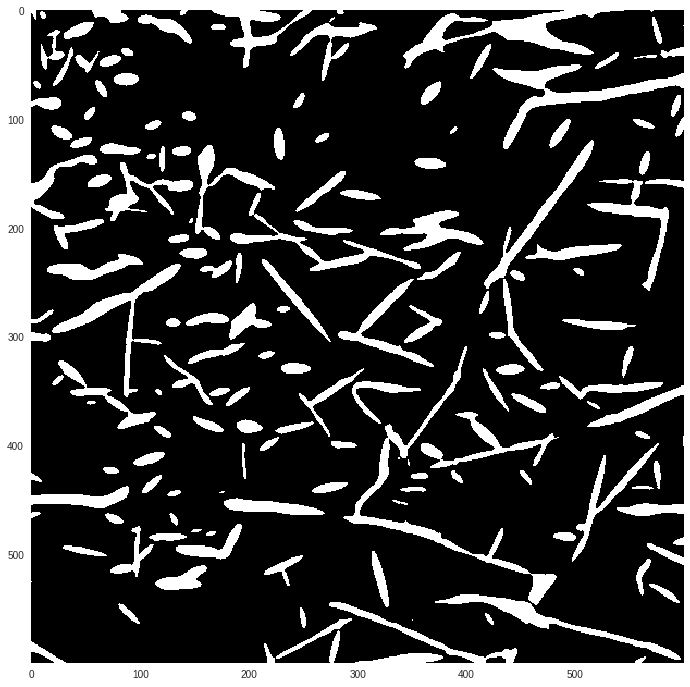

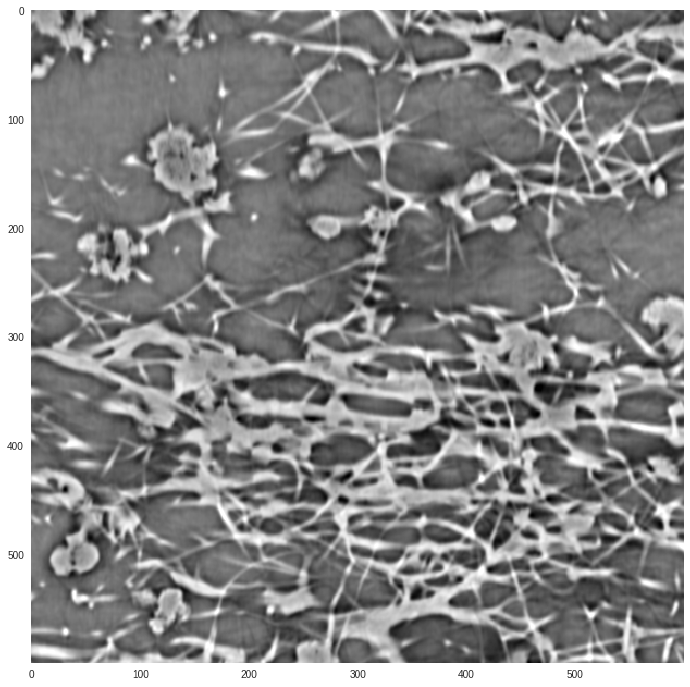

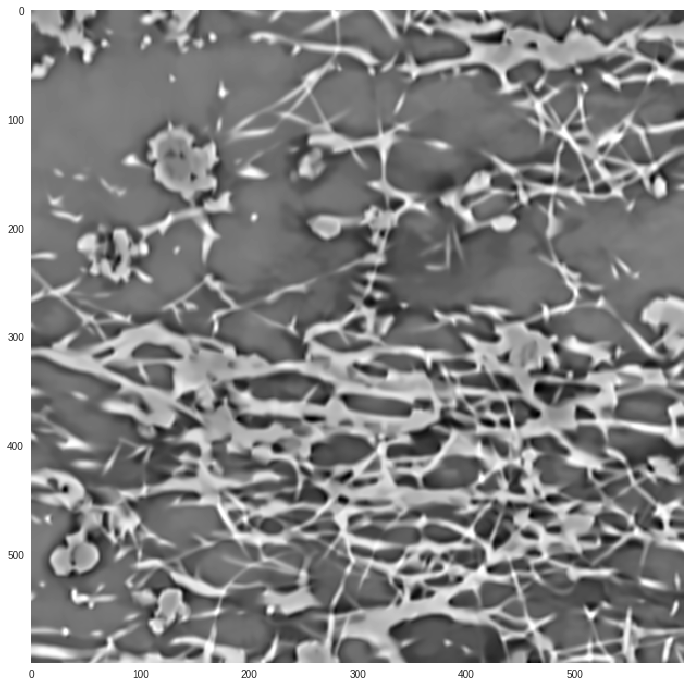

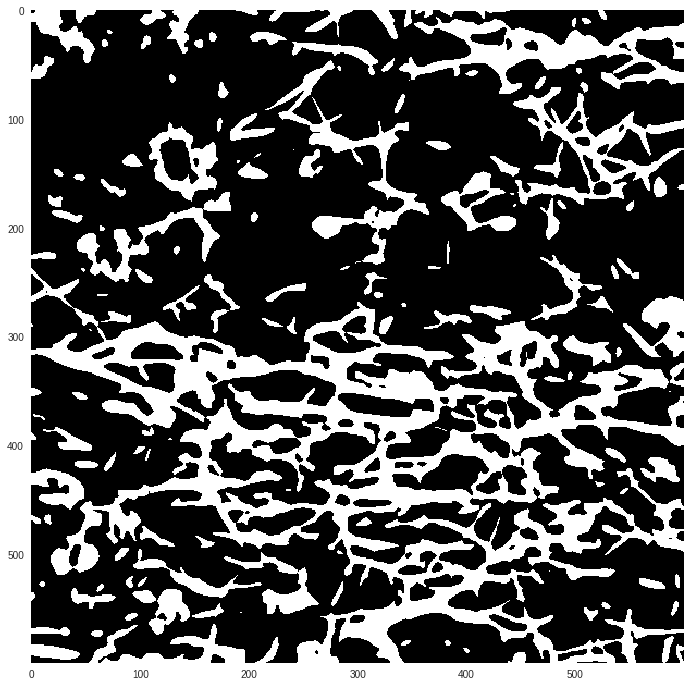

In [77]:
for ipath in input_paths:
    process_dataset(ipath, '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results')

## Diameter barcharts

In [132]:
diameter_paths = prepare_paths('/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/*_diameter.npy')

In [133]:
diameter_paths

['/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample9_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample1_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample4_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample7_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample2_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample5_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample3_diameter.npy',
 '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/sample6_diameter.npy']

In [134]:
for sm in ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7', 'sample9']:
    print sm
    sm_path = '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/{}_diameter.npy'.format(sm)
    csv_path = '/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/{}_diameter_values.csv'.format(sm)
    
    dmtr = np.load(sm_path).item()['diameter']
    dmtr = dmtr[dmtr > 0].flatten()
    pd.DataFrame({'Diameter': dmtr * 1.22}).to_csv(csv_path)

sample1
sample2
sample3
sample4
sample5
sample6
sample7
sample9


In [135]:
def plot_diameter(dmtr_path, num_bins, rng=(0,30), unit_scale=1.22, output_dir=None, name=None):
    dmtr = np.load(dmtr_path).item()['diameter']
    dmtr = dmtr[dmtr > 0].flatten()
    dmtr = dmtr[(dmtr > rng[0]) & (dmtr <= rng[-1])]
    
    vis.plot_histogram_fig(dmtr * unit_scale, num_bins, 
                       np.linspace(0, 30, num=16).astype(np.int8),
                       '#E36F3C', xlabel='Diameter, [$\mu{m}$]', 
                       ylabel='Amount, [%]', figsize=(8.5,4.5),
                       xlim=(0, 30), ylim=(0, 0.3), in_percent=True, bar_width=1.,
                       output_dir=output_dir, name=name)

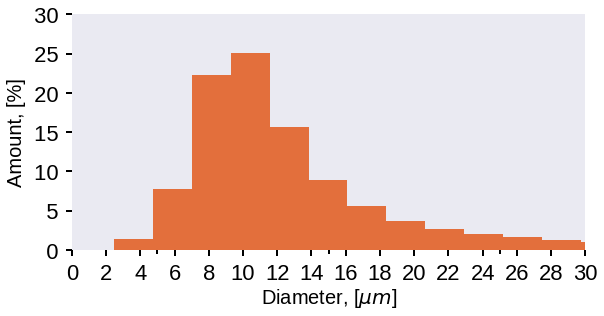

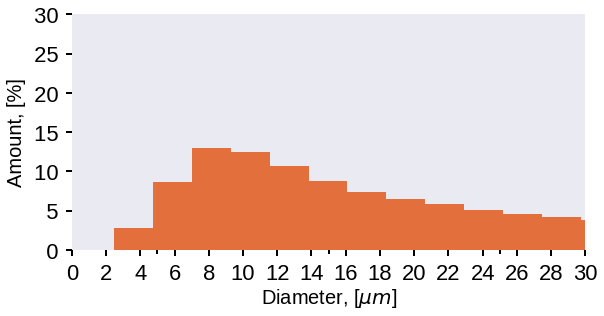

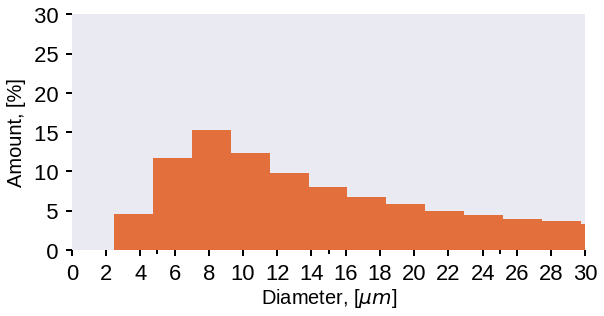

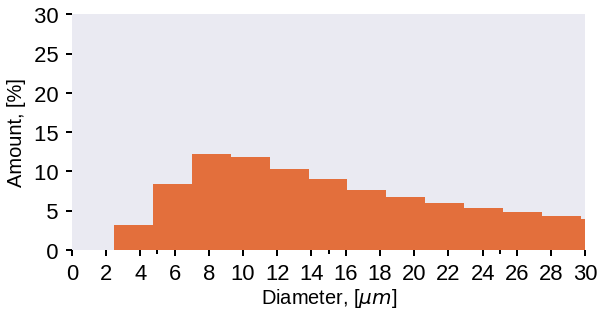

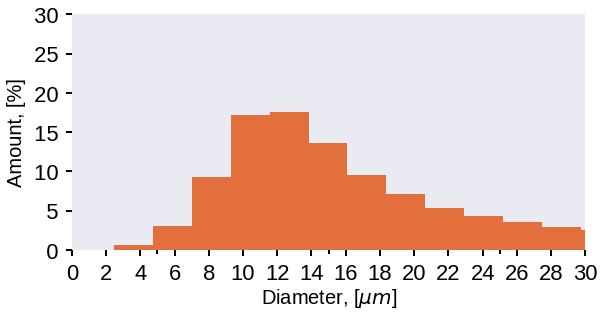

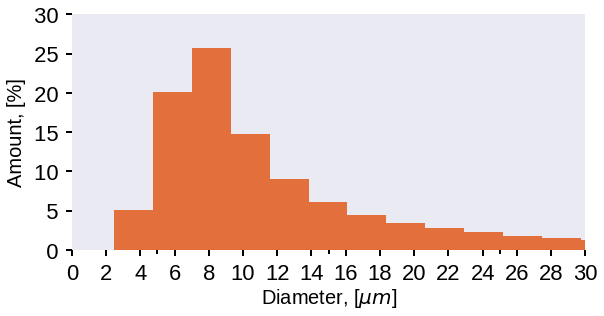

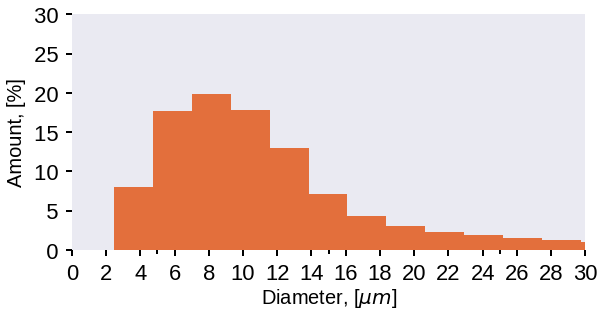

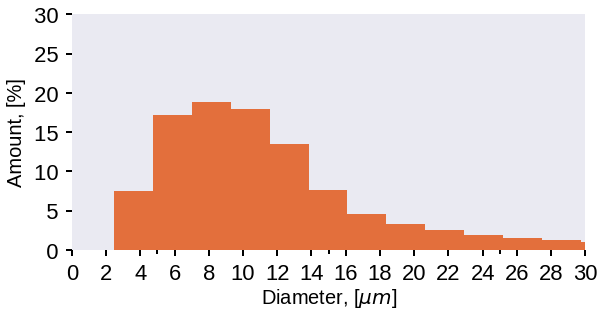

In [136]:
for sm in ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7', 'sample9']:
    plot_diameter('/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/{}_diameter.npy'.format(sm),
                  15, name=sm,
                  output_dir='/mnt/LSDF/projects/biomaterials/TopoTomo_2018_06_26/Analysis/analysis_cropped_results/plots')

## Porosity

In [118]:
def estimate_group_porosity(input_path, num_patches, side_size=(300,300)):
    data, basename = open_data(input_path, big_edian=True, regex_pattern=r'(?P<name>\w+\d+)_\d+\w+_\w+_\w+_\w+_(?P<bit>\d+\w+)_(?P<width>\d+)x(?P<height>\d+)x(?P<depth>\d+)')
    
    vindices = [get_random_patch_index(data.shape, (data.shape[0], side_size[0], side_size[1])) for i in range(num_patches)]
    patches = np.array([get_ndpatch(data, (data.shape[0], side_size[0], side_size[1]), idx) for idx in vindices])
    
    porosity = []
    
    for dpatch in patches:
        dpatch_8bit = convert_to_8bit(dpatch)[0]
        dpatch_segmented = (dpatch_8bit > filters.threshold_otsu(dpatch_8bit)).astype(np.uint8)

        pr = mrph.calc_porosity(dpatch_segmented)
        porosity.append(pr.values()[0])
        
    return basename, np.mean(porosity), np.std(porosity)

In [120]:
porosity_results = dict()
for ipath in input_paths:
    sample_name, mu_val, std_val = estimate_group_porosity(ipath, 10)
    porosity_results[sample_name] = dict(mean=mu_val, std=std_val)

(480, 600, 600) <type 'numpy.float32'>
('sample7', '32bit', (480, 600, 600))
(-0.0028420605295803396, 0.003871850452618706)
(-0.0027505340989679096, 0.003795703876996421)
(-0.0028163203972391784, 0.00381998205860146)
(-0.0026953336803708225, 0.003741955860750771)
(-0.0027369237527484075, 0.0037581692470703316)
(-0.0029986519422614947, 0.003938572485465565)
(-0.0028075722523964943, 0.003805606627603996)
(-0.0026951360071776433, 0.0037197433435358154)
(-0.0026843396506737918, 0.0037399921752512832)
(-0.002736249477718957, 0.003740614294307335)
(260, 600, 600) <type 'numpy.float32'>
('sample6', '32bit', (260, 600, 600))
(-0.00480292226485908, 0.0041156891216524785)
(-0.0046616299142595375, 0.004038807950913936)
(-0.0047042253544088445, 0.004182009493000807)
(-0.004902767483191565, 0.004147047655191298)
(-0.004845308618806303, 0.004126355053856973)
(-0.004645467740762979, 0.004090985776856598)
(-0.004773763487348333, 0.004088909832760695)
(-0.004919020477170124, 0.004306493794545535)
(-0.0

In [124]:
print '- Samples porosity'
for k, v in sorted(porosity_results.items()):
    print '{0}: {1:.2f}±{2:.3f} %'.format(k, v['mean'] * 100, v['std'] * 100)

- Samples porosity
sample1: 85.86±0.855 %
sample2: 72.08±0.909 %
sample3: 79.98±0.880 %
sample4: 78.02±0.399 %
sample5: 83.63±0.614 %
sample6: 87.40±0.301 %
sample7: 93.73±0.120 %
sample9: 93.50±0.124 %
